
# Model training on school level data #

Here we train linear regression and XGBoost models in order to predict SAT performance from demographic data at the school level. Each model is trained and evaluated with data corresponding to one state and year. Before training each model, we do a train/test split, reserving 15% of our data for our test set. At the time of training a model, we further split our training data into training and validation sets if necessary (for instance, if we need to optimize hyperparameters).

After each model has been trained (including hyperparameter optimization), it is evaluated using the test set for the corresponding state and year, which has not been used for training or validation. We then plot, in one graph for each state, the RMSE values corresponding to each year. We also plot the RMSE values that correspond to baseline models, as a means to evaluate our models' performance.

In [196]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


## The main model training loop ##

Here we...

TODO: Fix graph x axis labels

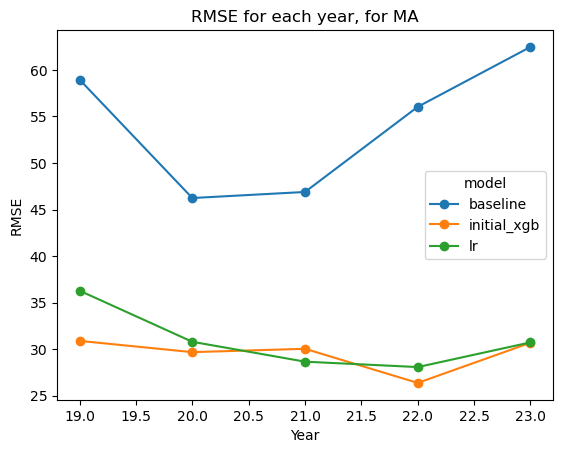

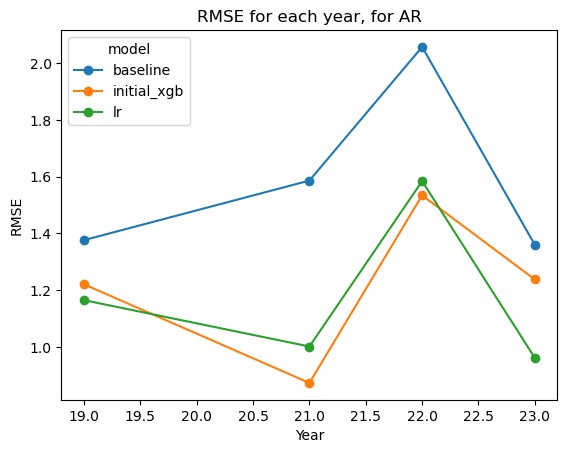

In [205]:
import matplotlib.pyplot as plt
import os

states = ['MA', 'AR']
years  = [19,20,21,22, 23]
results = []

trained_models = []

feature_names_dict = {}

for state in states:
    for year in years:
        if year == 20 and state == 'AR':
            continue
        df = load_data_and_select_cols(state, year)
        X, y = process_data(df, state)
        
        X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.15)
        
        metrics, models = train_and_evaluate_models(X_tr, y_tr, X_test, y_test)
        metrics.update(state=state, year=year)
        models.update(state = state, year = year)
        
        results.append(metrics)
        trained_models.append(models)
        
        feature_names_dict[(state,year)] = list(X.columns)


df_res = pd.DataFrame(results)


import matplotlib.pyplot as plt

df_long = df_res.melt(
    id_vars=['year', 'state'],
    value_vars=['rmse_baseline', 'rmse_lr', 'rmse_initial_xgb'],
    var_name='model',            # this will be 'rmse_baseline', etc.
    value_name='rmse'
)

df_long['model'] = df_long['model'].str.replace('rmse_', '')

# plot the RMSEs for the different models in the same plot, for each state

for state in df_long['state'].unique():
    # filter for this state
    sub = df_long[df_long['state'] == state]
    
    # pivot so columns are models
    pivot = sub.pivot(index = 'year', columns = 'model', values = 'rmse')
    
    # plot RMSEs for all state models in one figure
    ax = pivot.plot(marker = 'o', title = f"RMSE for each year, for {state}")
    ax.set_xlabel('Year')
    ax.set_ylabel('RMSE')
    ax.legend(title = 'model')
    plt.show()

## Studying feature importance ##

In the loop above, we trained linear and XGBoost models for each state and year. We have stored the trained models in `trained_models`, and now we will look into which features are most important for these models.

TODO: 
- in order to do this, use models trained on all the data, not just the training set. this is not prediction!
- comment code and etc.
- for MA, add feature (tests taken)/student


### Feature importance with linear regression ###

Top 10 positive coefficients:
 perc_other_race                          0.490055
number_of_students                       0.264318
perc_test_taking_grades_9_12_students    0.233211
is_open_enrollment_charter               0.111892
dtype: float64 

Top 10 negative coefficients:
 perc_african_american   -0.632267
perc_frl                -0.614340
perc_hispanic           -0.200960
dtype: float64


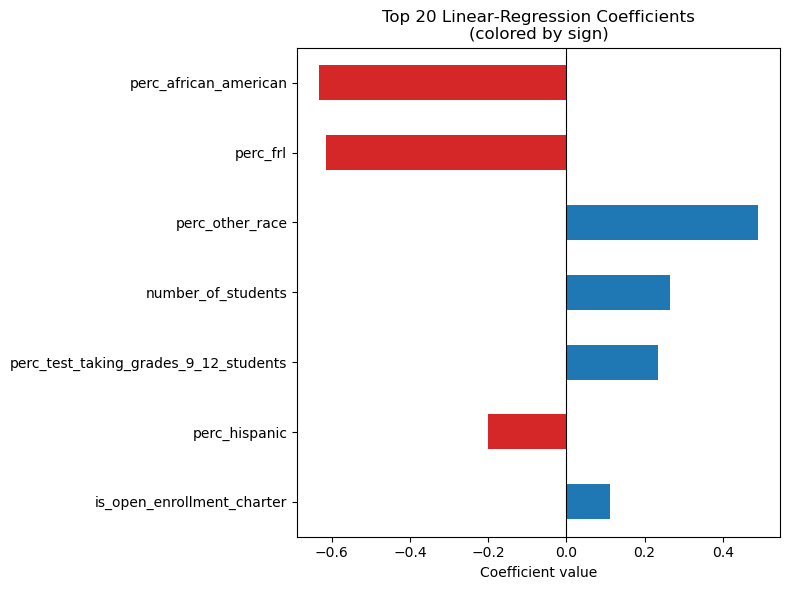

In [202]:
state = 'AR'
year = 22

df = load_data_and_select_cols(state, year)
X, y = process_data(df, state)

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.15)

metrics, models = train_and_evaluate_models(X_tr, y_tr, X_test, y_test)

models.update(state = state, year = year)

lin = models['lr']

features = X_tr.columns

coef = pd.Series(lin.coef_, index=X_tr.columns)

# sort by absolute value descending
coef_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)

# top 10 positive and top 10 negative coeffs
top_pos = coef[coef > 0].sort_values(ascending=False).head(10)
top_neg = coef[coef < 0].sort_values().head(10)

print("Top 10 positive coefficients:\n", top_pos, "\n")
print("Top 10 negative coefficients:\n", top_neg)

# ─── 2) Visualize them in one diverging bar chart ────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

# Take the top 20 (by absolute) to keep the plot readable
to_plot = coef_sorted.head(20)

# Assign colors by sign
colors = ['tab:blue' if v > 0 else 'tab:red' for v in to_plot]

to_plot.plot.barh(ax=ax, color=colors)
ax.set_title("Top 20 Linear‑Regression Coefficients\n(colored by sign)")
ax.set_xlabel("Coefficient value")
ax.invert_yaxis()      # largest at top
ax.axvline(0, color='black', linewidth=0.8)  # central zero line
plt.tight_layout()
plt.show()




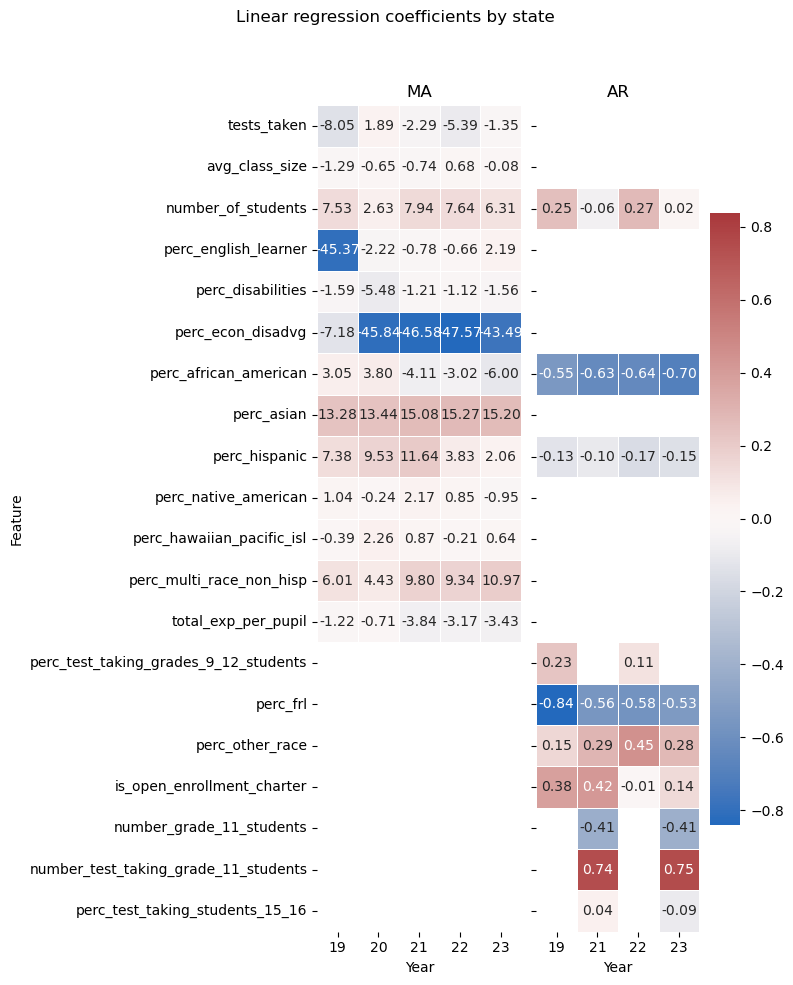

In [206]:
records = []
for rec in trained_models:
    state, year = rec['state'], rec['year']
    feature_names = feature_names_dict[(state,year)]
    
    lin = rec['lr']       
    coefs = pd.Series(lin.coef_, index=feature_names, name=(state, year))
    
    # turn into a dataframe with a MultiIndex column
    records.append(coefs)
# concat into one DF: rows = features, cols = (state,year)
coef_wide = pd.concat(records, axis=1)
coef_wide.columns = pd.MultiIndex.from_tuples(coef_wide.columns,
                                              names=['state','year'])


states = coef_wide.columns.get_level_values('state').unique()
n_states = len(states)

fig, axes = plt.subplots(1, n_states, sharey=True,
                         figsize=(n_states*4, coef_wide.shape[0]*0.5))

# make sure axes is iterable
if n_states == 1:
    axes = [axes]

for ax, state in zip(axes, states):
    sub = coef_wide.xs(state, axis=1, level='state')
    
    # compute per‐state color scale, ignoring NaNs
    vmax = sub.abs().max().max()

    sns.heatmap(
        sub,
        center=0,
        cmap='vlag',
        annot=sub.round(2),
        fmt='.2f',
        vmin=-vmax, vmax=vmax,
        linewidths=0.5,
        cbar=(ax is axes[-1]),
        ax=ax
    )
    ax.set_title(state)
    ax.set_xlabel("Year")

axes[0].set_ylabel("Feature")
plt.suptitle("Linear regression coefficients by state")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


## Auxiliary functions ##

### The model training function ###

The function `train_and_evaluate_models` trains (three) models on our training data: a baseline model, a linear regression model, and an XGBoost model.
Metrics for each of these are computed using the test set, and returned in a dictionary.

TODO:add more XGBoost models with hyperparameter tuning, just copy from the old notebook. add docstrings?

In [85]:
def train_and_evaluate_models(X_tr, y_tr, X_test, y_test):
    metrics = {}
    models = {}
    
    # baseline model
    y_mean = np.mean(y_tr)
    y_pred_baseline = np.full_like(y_test, fill_value=y_mean)
    
    # get the metrics for the baseline model and store them
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)
    rmse_baseline = np.sqrt(mse_baseline)
    r2_baseline = r2_score(y_test, y_pred_baseline)

    metrics['mse_baseline'] = mse_baseline
    metrics['rmse_baseline'] = rmse_baseline
    metrics['r2_baseline'] = r2_baseline

    # Linear model

    # need to scale features, especially since we want to use the model coefficients later.
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_tr, y_tr)

    y_pred_lr = pipe.predict(X_test)
    
    # get the metrics for the linear regression model and store them
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mse_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    metrics['mse_lr'] = mse_lr
    metrics['rmse_lr'] =  rmse_lr
    metrics['r2_lr'] = r2_lr

    # get the model from the pipeline and store it
    models['lr'] = pipe.named_steps['linearregression']

    # xgboost model(s)
    initial_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6, 'early_stopping_rounds': 10}
    
    # we want our training set to be 70% of the original data, and our validation set 15%.
    X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size = 0.15/0.85)
    
    xgb_regressor = xgb.XGBRegressor(**initial_params)
    
    # evaluation on the validation set for early stopping:
    eval_set = [(X_val, y_val)]
    xgb_regressor.fit(X_train, y_train, eval_set = eval_set, verbose = 0)
    
    # get the metrics for the initial xgboost model
    y_pred_initial_xgb = xgb_regressor.predict(X_test)
    
    mse_initial_xgb = mean_squared_error(y_test, y_pred_initial_xgb)
    rmse_initial_xgb = np.sqrt(mse_initial_xgb)
    r2_initial_xgb = r2_score(y_test, y_pred_initial_xgb)

    metrics['mse_initial_xgb'] = mse_initial_xgb
    metrics['rmse_initial_xgb'] = rmse_initial_xgb
    metrics['r2_initial_xgb'] = r2_initial_xgb

    models['initial_xgb'] = xgb_regressor
    
    return metrics, models

### Loading data and selecting columns ###

The function `load_data_and_select_cols` loads the dataframe with our data, and selects the relevant columns to be used for training models. Since data for different states contains different features, we need to deal with each state separately.

In [154]:
def load_data_and_select_cols(state, year):

    folder = os.path.join(r'C:\Users\mauro\OneDrive\Desktop\MATH\Spring_2025\Erdos\project\project_files\data', state + str(year))
    filename = state + str(year) + '_cleaned_ed_school_demographics.csv' 
    filepath = os.path.join(folder, filename)
    df = pd.read_csv(filepath)

    test_type_dict = {'AR':'ACT', 'MA' : 'SAT'}
    test_type = test_type_dict[state]
    
    drop_cols = []
    
    if state == 'AR':
        # we drop columns which directly relate to test results: it is very likely that, e.g. science ACT results correlate highly with math ACT results.
        other_test_results = ['perc_math_readiness',
                                'perc_english_readiness', 'perc_reading_readiness',
                                'perc_science_readiness', 'perc_all_subject_readiness',
                                'ACT_english', 'ACT_reading', 'ACT_science',' Average % ACT Composite Score ',
                             'Average ACT Composite Score']
        # now we drop other features that we will not use.
        irrelevant_features = ['school_name', 'Grades', 'Grade', 'District Name','Region', 'County', 'School LEA', 
                               'DLEA', 'year',' Number of Students in Grades 9-12 ', 'Year',
                               ' % Students in grade 9-12 that took the ACT2', '% of Exams that scored 3 or Above',
                               'number_AP_exam_taking_students', 'number_AP_exams_taken'
                              ]
        other_drop = ['perc_white', 'perc_minority']
        drop_cols += other_test_results + irrelevant_features + other_drop
        drop_cols = [col for col in drop_cols if col in list(df.columns)]
        
    elif state == 'MA':
        other_test_results = ['SAT_reading_writing']
        irrelevant_features = ['school_name', 'School Code', 'Total # of Classes', 'Female %', 'Male %','District Code',
                               'District Name', 'In-District Expenditures','Total In-district FTEs', 'In-District Expenditures per Pupil',
                               'Total Expenditures', 'Total Pupil FTEs', 'year'
                              ]
        # cannot have all the % ethnicities as features, since they would always sum to 100
        other_drop = ['perc_white']
        drop_cols += irrelevant_features + other_test_results + other_drop
        
        drop_cols = [col for col in drop_cols if col in list(df.columns)]
        
    elif state == 'IL':
        raise NotImplementedError()

    df = df.drop(drop_cols, axis = 1)

    return df


The function `process_data` simply splits the dataframe `df` into the dataframe corresponding to features and the series representing the target variable, and returns them separately.

In [14]:
def process_data(df, state):
    test_type_dict = {'AR': 'ACT', 'MA':'SAT'}
    test_type = test_type_dict[state]
        
    y = df[test_type + "_math"]
    X = df.drop(test_type + '_math', axis = 1)

    return X, y

    
    